Loading network trained

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf

from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from importlib import reload

In [2]:
import sys
import os
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE.layers as layers
from tools_for_VAE import utils, vae_functions, generator, model

In [3]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [4]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate, LeakyReLU

In [5]:
tfd = tfp.distributions

In [6]:
import tensorflow

# Parameters

In [7]:
nb_of_bands = 6
batch_size = 100 

input_shape = (64, 64, nb_of_bands)
hidden_dim = 256
latent_dim = 32
final_dim = 2
filters = [32, 64, 128, 256]
kernels = [3,3,3,3]

conv_activation = None
dense_activation = None

bands = [4,5,6,7,8,9]

# Batchgenerator

In [8]:
images_dir = '/sps/lsst/users/barcelin/data/TFP/GalSim_COSMOS/isolated_galaxies/centered/'
list_of_samples = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('.npy')]
list_of_samples_val = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'validation')) if x.endswith('.npy')]

In [9]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [10]:
test_generator = generator.BatchGenerator_ellipticity(bands, list_of_samples, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='training',
                                    do_norm=True,
                                    denorm = False,
                                    list_of_weights_e=None)


[BatchGenerator] total_sample_size =  20000
[BatchGenerator] len(list_of_samples) =  2


In [11]:
test = test_generator.__getitem__(2)

In [12]:
test[0].shape

(100, 64, 64, 6)

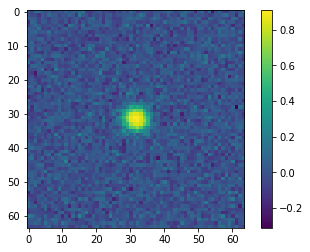

In [13]:
plt.imshow(test[0][1,:,:,4])
plt.colorbar()

# Model avec latent space

In [14]:
encoder, decoder = model.vae_model(latent_dim, final_dim, len(bands))

In [15]:
net = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

In [16]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [17]:
net.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss=negative_log_likelihood)

# Loading weights

In [18]:
reload(model)

<module 'tools_for_VAE.model' from '../../scripts/tools_for_VAE/tools_for_VAE/model.py'>

In [33]:
loading_path = '/sps/lsst/users/barcelin/TFP/weights/shapes/test3/'#3

latest = tf.train.latest_checkpoint(loading_path)
net.load_weights(latest)

In [34]:
test = test_generator.__getitem__(2)

out = net(test[0])

In [35]:
test_out_encoder = encoder(test[0])

In [36]:
test_out_encoder[0].numpy()

array([ 0.11018496, -1.0066785 ,  0.11124106,  0.70521134, -0.6563139 ,
       -0.00546005, -0.9947248 , -0.265501  ,  1.6575842 , -0.91943574,
        0.67458266,  1.6161298 , -0.39481264,  0.7847864 ,  0.35980356,
        1.8474557 ,  1.1052774 ,  0.37951073, -0.51715606, -0.8986165 ,
        0.3517393 ,  0.5332824 ,  0.67021537, -0.26883543, -0.530859  ,
        0.8026963 ,  0.3117528 , -0.54267645, -0.5784168 ,  0.9591478 ,
       -0.50217104,  0.08619036], dtype=float32)

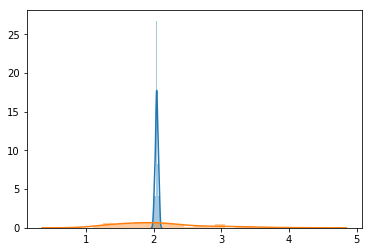

In [37]:
sns.distplot(out.mean().numpy()[:,0], bins = 20)
sns.distplot(test[1][:,0], bins = 20)

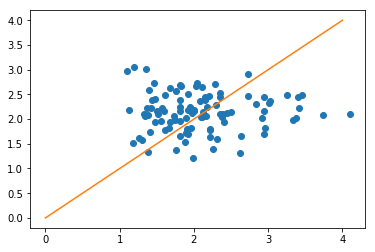

In [38]:
plt.plot(test[1][:,0], out[:,0].numpy(), 'o')
x = np.linspace(0,4)
plt.plot(x, x)

In [39]:
out[:,0].numpy().shape

(100,)

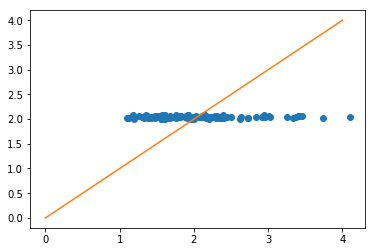

In [40]:
plt.plot(test[1][:,0], out.mean().numpy()[:,0], 'o')
x = np.linspace(0,4)
plt.plot(x, x)

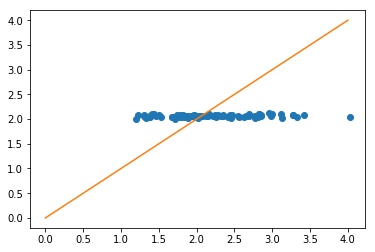

In [41]:
plt.plot(test[1][:,1], out.mean().numpy()[:,1], 'o')
x = np.linspace(0,4)
plt.plot(x, x)

One sampling for 100 images (one batch)

Text(0.5, 1.0, '$e2$')

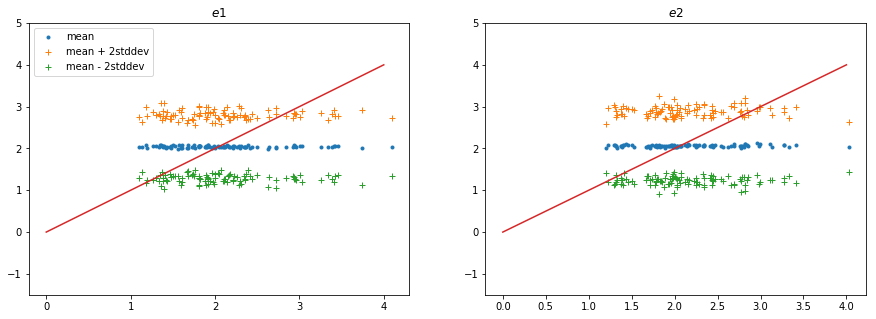

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(test[1][:,0], out.mean().numpy()[:,0], '.', label = 'mean')
axes[0].plot(test[1][:,0], out.mean().numpy()[:,0]+ 2*out.stddev().numpy()[:,0], '+', label = 'mean + 2stddev')
axes[0].plot(test[1][:,0], out.mean().numpy()[:,0]- 2*out.stddev().numpy()[:,0], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[0].plot(x, x)
axes[0].legend()
axes[0].set_ylim(-1.5,5)
axes[0].set_title('$e1$')

axes[1].plot(test[1][:,1], out.mean().numpy()[:,1], '.', label = 'mean')
axes[1].plot(test[1][:,1], out.mean().numpy()[:,1]+ 2*out.stddev().numpy()[:,1], '+', label = 'mean + 2stddev')
axes[1].plot(test[1][:,1], out.mean().numpy()[:,1]- 2*out.stddev().numpy()[:,1], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[1].plot(x, x)
#plt.xlim(0,4)
axes[1].set_ylim(-1.5,5)
axes[1].set_title('$e2$')

N samplings for 100 images (one batch)

In [140]:
N = 100
means = np.zeros((N,100))
stddevs = np.zeros((N,100))
outs = np.zeros((N,100))
for i in range (N):
    out = net(test[0])
    outs[i] = out[:,0].numpy()
    means[i] = out.mean().numpy()[:,0]
    stddevs[i] = out.stddev().numpy()[:,0]

KeyboardInterrupt: 

In [ ]:
image_nb = 0

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means[:,image_nb] + stddevs[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means[:,image_nb] - stddevs[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test[1][image_nb,0], color = 'r')
axes[0].legend()
print(test[1][image_nb,0])

axes[1].imshow(test[0][image_nb,:,:,2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i in range (len(means)):
    x = np.linspace(0,4, 1000)
    axes[0].plot(x, (1/(stddevs[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means[i,image_nb])/(2*stddevs[i,image_nb]**2))), color = 'grey', alpha = 0.3)
mean_means = np.mean(means[:,image_nb])
mean_stddevs = np.mean(stddevs[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].set_xlim(np.min(means[:,image_nb] - stddevs[:,image_nb]), np.max(means[:,image_nb] + stddevs[:,image_nb]))
axes[0].axvline(test[1][image_nb,0], color = 'r')

axes[1].imshow(test[0][image_nb,:,:,2])

In [ ]:
sns.distplot(outs[:,image_nb], bins = 20, label = 'means')

In [ ]:
image_nb = 1

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means[:,image_nb] + stddevs[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means[:,image_nb] - stddevs[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test[1][image_nb,0], color = 'r')
axes[0].legend()
print(test[1][image_nb,0])

axes[1].imshow(test[0][image_nb,:,:,2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i in range (len(means)):
    x = np.linspace(0,4, 1000)
    axes[0].plot(x, (1/(stddevs[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means[i,image_nb])/(2*stddevs[i,image_nb]**2))), color = 'grey', alpha = 0.3)
mean_means = np.mean(means[:,image_nb])
mean_stddevs = np.mean(stddevs[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].set_xlim(np.min(means[:,image_nb] - stddevs[:,image_nb]), np.max(means[:,image_nb] + stddevs[:,image_nb]))
axes[0].axvline(test[1][image_nb,0], color = 'r')

axes[1].imshow(test[0][image_nb,:,:,2])

# Model avec dense variational

In [146]:
reload(model)

<module 'tools_for_VAE.model' from '../../scripts/tools_for_VAE/tools_for_VAE/model.py'>

In [147]:
encoder = model.net_model(final_dim, len(bands))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu_19 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_20 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
p_re_lu_21 (PReLU)           (None, 32, 32, 64)       

In [175]:
net_dvar = Model(inputs=encoder.inputs, outputs = encoder(encoder.inputs))

In [200]:
loading_path = '/sps/lsst/users/barcelin/TFP/weights/shapes/test2/'

latest = tf.train.latest_checkpoint(loading_path)
net_dvar.load_weights(latest)

In [201]:
out_dvar = net_dvar(test[0])

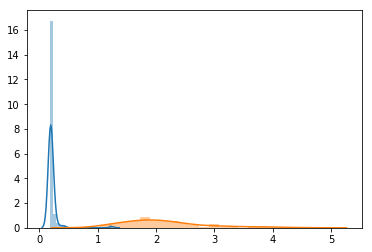

In [202]:
sns.distplot(out_dvar.mean().numpy()[:,0], bins = 20)
sns.distplot(test[1][:,0], bins = 20)

(-1.5, 4)

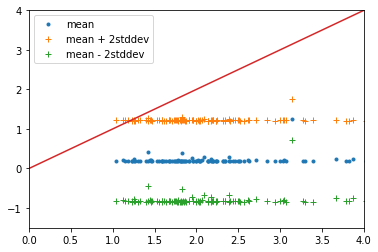

In [203]:
fig = plt.figure()
plt.plot(test[1][:,0], out_dvar.mean().numpy()[:,0], '.', label = 'mean')
plt.plot(test[1][:,0], out_dvar.mean().numpy()[:,0]+ 2*out_dvar.stddev().numpy()[:,0], '+', label = 'mean + 2stddev')
plt.plot(test[1][:,0], out_dvar.mean().numpy()[:,0]- 2*out_dvar.stddev().numpy()[:,0], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
plt.legend()
plt.plot(x, x)
plt.xlim(0,4)
plt.ylim(-1.5,4)

In [158]:
N = 50
means_dvar = np.zeros((N,100))
stddevs_dvar = np.zeros((N,100))
for i in range (N):
    out_dvar = net_dvar(test[0])
    means_dvar[i] = out_dvar.mean().numpy()[:,0]
    #print(means_dvar[i][0])
    stddevs_dvar[i] = out_dvar.stddev().numpy()[:,0]

0.0013365065678954124
0.12101632356643677
0.001391108613461256
0.0038110599853098392
0.23697465658187866
0.40158146619796753
0.0274982750415802
0.00713554210960865
0.0019079637713730335
0.7798060178756714
0.0009332026238553226
0.00016884396609384567
0.005873351823538542
0.0001557868527015671
0.0033060493879020214
0.1809670329093933
1.1013896465301514
0.002214279258623719
0.0015979539602994919
0.4243263006210327
0.002893769880756736
0.0018315956695005298
0.9475554823875427
0.8054245114326477
0.013905644416809082
0.0019565029069781303
0.37074989080429077
1.96091628074646
0.002477145055308938
0.0067873066291213036
0.0016814208356663585
0.0048088389448821545
0.22703030705451965
0.006682247389107943
0.007177593652158976
0.0018356729997321963
1.3364574909210205
0.0002515563101042062
0.0026699178852140903
0.0007370566017925739
0.7185571193695068
0.003264934988692403
0.0028096912428736687
0.0014750277623534203
0.6362238526344299
1.4328817129135132
0.952980101108551
2.190131187438965
0.00322986

In [ ]:
sns.distplot(means_dvar[:,0], bins = 20)